# Analysis of Public Comments Regarding the EPA's Revised Definition of "Waters of the United States" (WOTUS)

This project's background, overview, and a full write-up are posted on the [repository website](https://data-science-for-conservation.github.io/WOTUS_Revision/)

The goals of this project are to:

- Apply unsupervised learning algorithms to better understand the core themes in the comments (topic analysis) and to identify similar comments to new or unseen ones (cosine similarity)
- Evaulate the results of clustering algorithms to determine if they're suitable proxies for supervised sentiment analysis
- Train, optimize, and deploy a classifier for sentiment analysis on a limited labeled sample of comments

**Table of Contents**

- [Library Imports](#library-imports)
- [Data Cleaning and Helper Functions](#data-cleaning)
- [Data Pre-Processing](#data-preprocessing)
- [Exploratory Data Analysis](#eda)
- [Topic Analysis](#topic-analysis)
- [Clustering Analysis](#clustering-analysis)
- [Sentiment Analysis](#sentiment-analysis)
- [Conclusions](#conclusions)


## <a name="library-imports"></a>Library Imports

In [1]:
# Standard imports
import re
import sys
import warnings
warnings.filterwarnings('ignore', 'DeprecationWarning') 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Model and analysis imports
from scipy import linalg

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA, TruncatedSVD, NMF, PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.utils import resample

In [3]:
# Un-comment the code below and run cell (if needed) to install spaCy and DL
#   the large language model (necessary to access word embeddings)
# !conda install --yes --prefix {sys.prefix} spacy
# !{sys.executable} -m spacy download en_core_web_lg

In [4]:
# Un-comment and run cell (if needed) to install Wordcloud package
# !{sys.executable} -m pip install wordcloud

In [5]:
# Un-comment and run cell (if needed) to install pyLDAVis package
# !{sys.executable} -m pip install pyldavis

In [6]:
# Other imports from PIP
import spacy
from wordcloud import WordCloud
import pyLDAvis.sklearn

## <a name="data-cleaning"></a>Data Cleaning and Helper Functions

In [7]:
full_df = pd.read_pickle('./Data/full_labeled.pkl')

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment,Support_Rule_Change
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,0.0
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,0.0
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...,0.0
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,...",0.0
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...,0.0


In [8]:
# Segment comments and labels, drop duplicate comments, remove comment box artifacts
comments = full_df.loc[:, ['Comment', 'Support_Rule_Change']]
print('BEFORE:')
print(comments.loc[5993, 'Comment'])

comments.drop_duplicates(['Comment'], inplace=True)

comments['Comment'] = comments['Comment'].apply(lambda s: s.replace('PLEASE WRITE YOUR COMMENT HERE:', ''))
print('AFTER:')
print(comments.loc[5993, 'Comment'])

BEFORE:
PLEASE WRITE YOUR COMMENT HERE:  It is my wish and request that the Waters of the United States regulation be repealed. Regards, Thomas Moore
AFTER:
  It is my wish and request that the Waters of the United States regulation be repealed. Regards, Thomas Moore


In [9]:
comments.head()

,Comment,Support_Rule_Change
0,I write to express my opposition to the Enviro...,0.0
1,I write to express my opposition to the Enviro...,0.0
2,Please abandon this proposed rollback of the 2...,0.0
3,"My husband and I have two wonderful daughters,...",0.0
4,Please do not change the definitions within th...,0.0


In [11]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7986 entries, 0 to 8186
Data columns (total 2 columns):
Comment                7986 non-null object
Support_Rule_Change    1200 non-null float64
dtypes: float64(1), object(1)
memory usage: 507.2+ KB


In [12]:
# Fill unlabeled comments with -1
comments.fillna(value=-1, axis=1, inplace=True)
comments.tail()

,Comment,Support_Rule_Change
8182,I object to the proposed changes. We NEED all ...,0.0
8183,I am 39 years old and thanks to the hard work ...,0.0
8184,I pray that EPA leadership come to the underst...,-1.0
8185,clean water is one of the absolute necesseties...,-1.0
8186,The Clean Water Rule provides clear protection...,0.0


In [13]:
# Split ALL comments into training and test sets. The X_train set,
#    which has all training comments, will be used for unsupervised techniques
X = comments.drop('Support_Rule_Change', axis=1)
y = comments['Support_Rule_Change']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6388, 1) (1598, 1) (6388,) (1598,)


In [14]:
# Create labeled-only sets from training and test sets to be
#    used in exploratory analysis and supervised learning
X_labeled_train = X_train[y_train != -1]
y_labeled_train = y_train[y_train != -1]

X_labeled_test = X_test[y_test != -1]
y_labeled_test = y_test[y_test != -1]

print(X_labeled_train.shape, y_labeled_train.shape, X_labeled_test.shape, y_labeled_test.shape)

(960, 1) (960,) (240, 1) (240,)


In [15]:
# Approximately 20% of the labeled comments were supportive of the rule change
print(np.mean(y_labeled_train))
y_labeled_train.value_counts()

0.203125


0.0    765
1.0    195
Name: Support_Rule_Change, dtype: int64

In [16]:
# Helper function to show top words per topics
def show_topics(Vh, vocab_array, n_top_words=8):
    """
    Returns a list of the n_top_words from topic matrix Vh
    :param Vh: a topic (rows) by vocabulary (cols) orthonormal matrix
    :param vocab_array: a Numpy array of the vocabulary terms
        from the documents used in the analysis
    :param n_top_words: int of how many words to show by topic
    :return: list of strings with top words by topic in Vh
    
    >>>show_topics(my_Vh_matrix[:4], vocab)
    ['space launch satellite nasa commercial market satellites data',
     'god atheists atheism religious believe argument religion true',
     'nasa space lunar available mars probe moon edu',
     'atheists religious atheism god religion believe belief atheist']
    """
    top_words = lambda t: [vocab_array[i] for i in np.argsort(t)[:-n_top_words-1:-1]]
    topic_words = ([top_words(t) for t in Vh])
    return [' '.join(t) for t in topic_words]

In [17]:
# Helper function to get and plot most common words
def get_most_common_words(count_data, count_vect, n=10, plot=True):
    """
    :param count_data: data after running a CountVectorizer.fit_transform()
    :param count_vect: a CountVectorizer() instance
    :param n: int for how many top words to plot
    :param plot: Boolean whether to show plot or not
    :return: lists for top n words; then plots a matplotlib.pyplot bar chart of
        top words by counts
    """
    words = count_vect.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    
    if plot:
        plt.figure(figsize=(8, 6))
        plt.bar(x_pos, counts, align='center')
        plt.xticks(x_pos, words, rotation=-45) 
        plt.xlabel('Words')
        plt.ylabel('Counts')
        plt.title('{} Most Common Words'.format(n))
        plt.show()
    
    return words

## <a name="data-preprocessing"></a>Data Pre-Processing

In [18]:
# Load language model
nlp = spacy.load('en_core_web_lg')

### Bag of Words

In [19]:
# Create custom tokenizer/lemmatizer for bag-of-words (BOW)
#   approach
lemmatizer = spacy.lang.en.English()

def spacy_tokenizer(doc):
    """
    Applies spaCy's built-in tokenizer pipeline capabilities to
        to keep a lemmatized version of each token for alpha-
        numeric word's only (excludes punctuation and whitespace)
    """
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if token.lemma_.isalnum()])

In [20]:
# Stop words
stop_words = list(nlp.Defaults.stop_words)
tokenized_stop_words = spacy_tokenizer(' '.join(stop_words))

In [21]:
# Create term-document matrix using a count vectorizer
count_vec = CountVectorizer(stop_words=tokenized_stop_words,
                            tokenizer=spacy_tokenizer,
                            max_df=0.90,
                            min_df=5)

count_data = count_vec.fit_transform(X_train['Comment'])
print(count_data.shape)

vocab = np.array(count_vec.get_feature_names())

(6388, 4144)


In [22]:
s = 200
print(vocab[s:s+100])

['admin' 'administer' 'administration' 'administrative' 'administrator'
 'admit' 'adopt' 'adoption' 'adult' 'advance' 'advantage' 'adverse'
 'adversely' 'advice' 'advise' 'advisory' 'advocacy' 'advocate'
 'aesthetic' 'affair' 'affect' 'afford' 'affordable' 'affront' 'afraid'
 'africa' 'afternoon' 'ag' 'age' 'agency' 'agencyadministrator'
 'agencyepa' 'agencys' 'agenda' 'agendum' 'agent' 'aggregate' 'aggressive'
 'ago' 'agree' 'agreement' 'agribusiness' 'agricultural' 'agriculture'
 'ahead' 'aid' 'aim' 'air' 'aka' 'akin' 'al' 'alabama' 'alan' 'alarm'
 'alaska' 'alexander' 'alga' 'algal' 'align' 'alike' 'alive' 'alleviate'
 'alliance' 'allison' 'allocate' 'allow' 'ally' 'almighty' 'alot' 'alter'
 'alteration' 'alternative' 'altogether' 'amanda' 'amaze' 'ambiguity'
 'ambiguous' 'amend' 'amendment' 'amenity' 'america' 'american'
 'americans' 'americas' 'amp' 'amphibian' 'ample' 'amy' 'analysis'
 'analyze' 'ancestor' 'ancient' 'anderson' 'andrew' 'angle' 'angler'
 'angry' 'animal' 'ann' 'an

In [23]:
# Create term-document matrix using TF-IDF vectorizer
tf_vec = TfidfVectorizer(stop_words=tokenized_stop_words,
                         tokenizer=spacy_tokenizer,
                         max_df=0.90,
                         min_df=5)

tf_data = tf_vec.fit_transform(X_train['Comment'])
print(tf_data.shape)

vocab_tf = np.array(tf_vec.get_feature_names())

(6388, 4144)


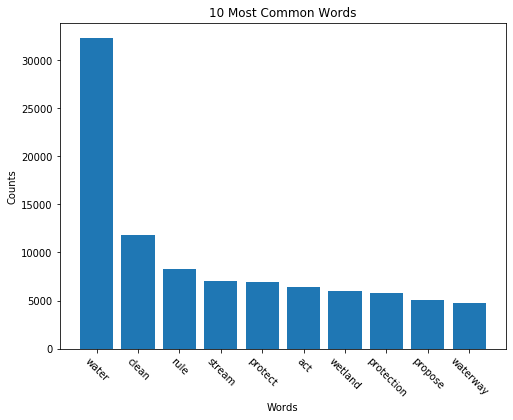

In [24]:
# Visualize 10 most common words
w = get_most_common_words(count_data, count_vec)

### Document Vectors

In [25]:
# Create document vector matrix using spaCy word vectors
#   from the large language model
doc_vecs = pd.DataFrame([nlp(text).vector for text in comments.Comment],
                        index=comments.index,
                        columns=['Vec_{}'.format(i) for i in range(1, 301)])
doc_vecs.shape

(7986, 300)

In [26]:
# Check that indices match
np.all(X.index == doc_vecs.index)

True

In [27]:
# Extract full and labeled train and test sets
doc_vec_train = doc_vecs.loc[X_train.index]
doc_vec_test = doc_vecs.loc[X_test.index]
doc_labeled_train = doc_vecs.loc[X_labeled_train.index]
doc_labeled_test = doc_vecs.loc[X_labeled_test.index]

print(doc_vec_train.shape, doc_vec_test.shape,
      doc_labeled_train.shape, doc_labeled_test.shape)

(6388, 300) (1598, 300) (960, 300) (240, 300)


## <a name="eda"></a>Exploratory Data Analysis

### Word Clouds for All Comments, Supporting Comments Only, and Opposing Comments Only

Word clouds can be useful to get an overview of the most common words (or bigrams, as in the analysis below) in a dataset of text. The first image was created using the entire training set, and provides a nice sanity check that there were no surprises. For example, if "immigration" showed up in the plot, there may be cause for concern on the integrity of the collected comments. But as expected, the most common bigram was "clean water". A closer inspection of the smaller-sized bigrams also uncovers the more opinionated phrases, such as "polluting industries", "dirty water", "clear rule", or "common sense".

Word clouds were also generated for subsets of labeled data to compare the vocabulary differences between supportive comments and opposing comments. No surprises here either - the supporting comments include "farm", "support proposed", and "clear rule" while the opposing ones mention "protection", "keep clean", and "drinking water". 

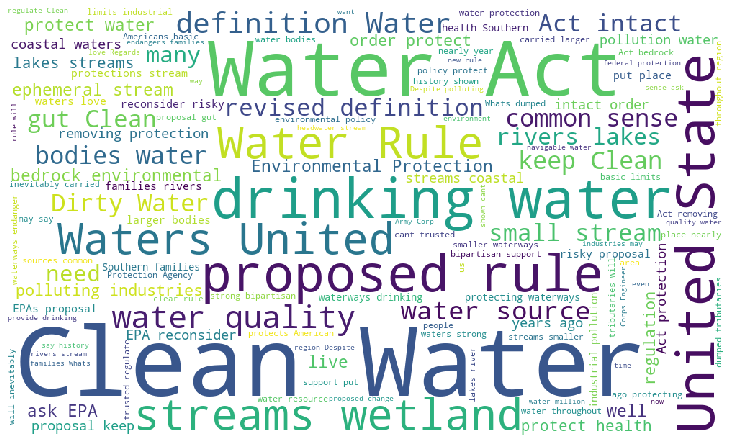

In [28]:
# Combine comments into one "text"
text_all = ' '.join(X_train['Comment'])

wordcloud_all = WordCloud(width = 1000,
                          height = 600, 
                          background_color ='white',
                          min_font_size = 10).generate(text_all)

# Plot the word cloud
plt.figure(figsize = (10, 6), facecolor=None);
plt.imshow(wordcloud_all);
plt.axis("off");
plt.tight_layout(pad=0);
plt.savefig('./Figures/wordcloud_all.png');
plt.show();

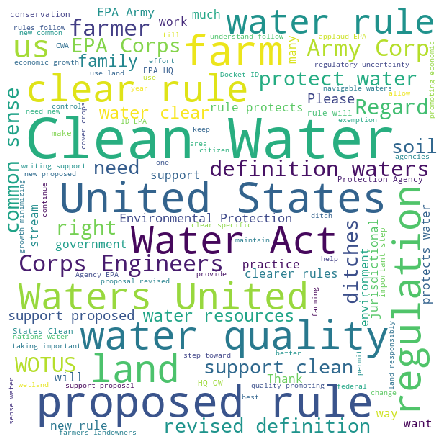

In [29]:
# Word cloud for SUPPORTIVE comments only
support_train = X_labeled_train[y_labeled_train == 1]

text_sup = ' '.join(support_train['Comment'])

wordcloud_sup = WordCloud(width = 600,
                          height = 600, 
                          background_color ='white',
                          min_font_size = 10).generate(text_sup)

# Plot the word cloud
plt.figure(figsize = (6, 6), facecolor=None);
plt.imshow(wordcloud_sup);
plt.axis("off");
plt.tight_layout(pad=0);
plt.savefig('./Figures/wordcloud_sup.png');
plt.show();

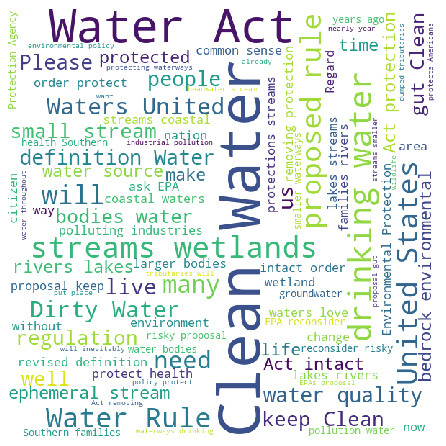

In [30]:
# Word cloud for OPPOSING comments only
oppose_train = X_labeled_train[y_labeled_train == 0]

text_opp = ' '.join(oppose_train['Comment'])

wordcloud_opp = WordCloud(width = 600,
                          height = 600, 
                          background_color ='white',
                          min_font_size = 10).generate(text_opp)

# Plot the word cloud
plt.figure(figsize = (6, 6), facecolor=None);
plt.imshow(wordcloud_opp);
plt.axis("off");
plt.tight_layout(pad=0);
plt.savefig('./Figures/wordcloud_opp.png');
plt.show();

### Comparison of Top Vocabulary by Type of Comment

In [31]:
# Top 50 words by supportive and opposing comments
sup_count_data = count_vec.transform(support_train['Comment'])
opp_count_data = count_vec.transform(oppose_train['Comment'])

w_sup = set(get_most_common_words(sup_count_data, count_vec, 50, False));
w_opp = set(get_most_common_words(opp_count_data, count_vec, 50, False));

In [32]:
# Overlapping words from supportive and opposing top 50

# Print format for summary site
# for w_b in sorted(list(w_sup.intersection(w_opp))):
#     print('<li>' + w_b + '</li>')

w_sup.intersection(w_opp)

{'act',
 'clean',
 'definition',
 'environmental',
 'epa',
 'family',
 'important',
 'need',
 'propose',
 'protect',
 'quality',
 'rule',
 'state',
 'unite',
 'water',
 'waterway'}

In [33]:
# Top supporting comment words not included in opposing comments

# Print format for summary site
# for w_s in sorted(list(w_sup - w_opp)):
#     print('<li>'+ w_s + '</li>')

w_sup - w_opp

{'2015',
 'agency',
 'army',
 'clarity',
 'clear',
 'common',
 'corp',
 'ditch',
 'engineer',
 'farm',
 'farmer',
 'federal',
 'follow',
 'help',
 'know',
 'land',
 'landowner',
 'new',
 'practice',
 'property',
 'provide',
 'regulate',
 'regulation',
 'regulatory',
 'resource',
 'revise',
 'right',
 'sense',
 'support',
 'time',
 'understand',
 'work',
 'wotus',
 'write'}

In [34]:
# Top opposing comment words not included in supporting comments

# Print format for summary site
# for w_o in sorted(list(w_opp - w_sup)):
#     print('<li>'+ w_o + '</li>')

w_opp - w_sup

{'allow',
 'body',
 'change',
 'community',
 'country',
 'dirty',
 'downstream',
 'drink',
 'environment',
 'ephemeral',
 'fish',
 'flow',
 'health',
 'include',
 'industry',
 'lake',
 'large',
 'live',
 'million',
 'oppose',
 'people',
 'place',
 'pollute',
 'pollution',
 'proposal',
 'protection',
 'remove',
 'river',
 'science',
 'small',
 'source',
 'stream',
 'wetland',
 'year'}

## <a name="topic-analysis"></a>Topic Analysis

### Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is a statistical model that finds the different mix of `n_components` topics that explain each comment. Comparing the perplexity metric of different numbers of topics is a quantitative way to help determine the appropriate number.

Per [Wikipedia's article on perplexity](https://en.wikipedia.org/wiki/Perplexity):

>In information theory, **perplexity** is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample. 

LDA analysis had much higher perplexity scores (~10x higher) using the TF-IDF vectorizer vs. the standard count vectorizer, so all analysis below shows the count vectorizer only.

In [35]:
# Compare perplexity scores to find optimal number of topics
p = []

print('-'*30)
for n in range(2, 23, 2):
    mod = LDA(n_components=n,
              n_jobs=-1,
              random_state=42)
    mod.fit(count_data)
    p.append(mod.bound_)
    print('Number of Topics: {}'.format(n))
    print('Perplexity score: {0:,.0f}'.format(mod.bound_))
    print('-'*30)

------------------------------
Number of Topics: 2
Perplexity score: 581
------------------------------
Number of Topics: 4
Perplexity score: 524
------------------------------
Number of Topics: 6
Perplexity score: 503
------------------------------
Number of Topics: 8
Perplexity score: 480
------------------------------
Number of Topics: 10
Perplexity score: 474
------------------------------
Number of Topics: 12
Perplexity score: 474
------------------------------
Number of Topics: 14
Perplexity score: 465
------------------------------
Number of Topics: 16
Perplexity score: 461
------------------------------
Number of Topics: 18
Perplexity score: 464
------------------------------
Number of Topics: 20
Perplexity score: 462
------------------------------
Number of Topics: 22
Perplexity score: 459
------------------------------


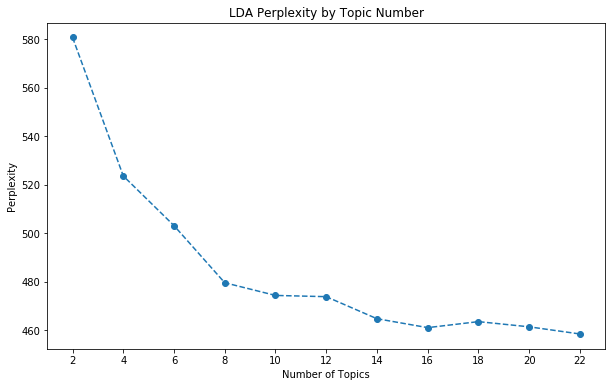

In [27]:
# Plot the perplexity scores
xtick = list(range(2, 23, 2))

plt.figure(figsize=(10, 6));
plt.xticks(xtick);
plt.plot(xtick, p, 'o--', c='#1f78b4');
plt.title('LDA Perplexity by Topic Number');
plt.ylabel('Perplexity');
plt.xlabel('Number of Topics');
# plt.savefig('./Figures/LDA_Perplexity_for_nTopics.png');
plt.show();

The sharpest decline in perplexity score happens from two to eight topics, with a flattening out thereafter. As lower perplexity scores are better but increasing the number of topics will generally keep reducing the metric, this is a case where the "elbow" method can be applied. The chart indicates that around 8 topics is where the law of diminishing returns kicks in. The next step is to review the topics qualitatively to determine if they fit the dataset.

While there's overlap in the language of several topics (see below), there's one clear topic for supportive comments while the rest seem to highlight different reasons to oppose it. Given the ratio of around 20% supportive comments in the corpus, 1-2 topics would be representative.

In [28]:
# Analyze output using 8 topics
n_topics = 8

lda = LDA(n_components=n_topics,
          n_jobs=-1,
          random_state=42)

X_by_topic = lda.fit_transform(count_data)  # TF-IDF had much higher overall perplexity scores

In [29]:
lda.components_.shape

(8, 4144)

In [30]:
print('Final perplexity score using {0} topics: {1:,.0f}'
      .format(n_topics, lda.bound_))  # TF-IDF perplexity: 2,698

Final perplexity score using 8 topics: 480


In [31]:
print('Top words for each topic:\n')

show_topics(lda.components_, vocab, 10)

Top words for each topic:



['water stream wetland clean rule protect downstream propose river flow',
 'water waterway clean rule act propose wetland protection protect state',
 'water rule farmer clean clear support propose epa land farm',
 'water wetland state definition propose protection change stream unite rule',
 'water clean protect people need regulation environment life live right',
 'water wetland clean protection park stream quality waterway propose rule',
 'water clean act protect waterway river stream drink proposal family',
 'water clean rule act community protection dirty epa propose polluter']

In [32]:
# Examplary comments by topic
print(X_by_topic.max(axis=0))

exem_idx = X_by_topic.argmax(axis=0)
exem_idx

[0.99638146 0.99628652 0.99654963 0.99757202 0.97495295 0.99788837
 0.99785307 0.99203323]


array([4208, 3456, 3878,  482, 1570, 2840, 3700, 3689])

In [33]:
X_by_topic[4208]

array([9.96381455e-01, 5.16948280e-04, 5.16964893e-04, 5.16864838e-04,
       5.16808724e-04, 5.16976793e-04, 5.16979055e-04, 5.17002177e-04])

In [34]:
# Print the exemplary comments for each topic
for i, idx in enumerate(exem_idx, 1):
    print('-'*30)
    print('Topic: {}'.format(i))
    print(X_train.iloc[idx]['Comment'])

------------------------------
Topic: 1
Clean streams have been a benefit provided by improved water technology.  Let's not go back to the past.I am opposed to the proposed rule because it fails to adequately protect streams and wetlands. If enacted, the rule would erase basic Clean Water Act protections for millions of acres of wetlands and millions of miles of rivers and streams across the country, including small headwater streams that may not flow continuously year-round. These "intermittent and ephemeral" streams, even if small, are significant to the health of downstream lands and waters; continuing to protect these areas is essential. The proposed replacement ignores the sound science that tells us streams and wetlands are connected to the larger water bodies downstream. Allowing small streams and wetlands to be destroyed will put downstream habitat and drinking water at risk by allowing pollution to flow more freely downstream. To be effective, the Clean Water Act must be able 

In [35]:
# Create pipeline to process raw text of test comments
lda_count_pipe = make_pipeline(count_vec, lda)

In [36]:
# Randomly select two labeled, test-set comments
np.random.seed(42)

# Select a supportive comment
sup_idx = np.random.choice(X_labeled_test[y_labeled_test == 1].index)
comm_sup = X_labeled_test.loc[sup_idx]['Comment']
print('Supportive comment:')
print(comm_sup)
print()

# Select a supportive comment
opp_idx = np.random.choice(X_labeled_test[y_labeled_test == 0].index)
comm_opp = X_labeled_test.loc[opp_idx]['Comment']
print('Opposing comment:')
print(comm_opp)

Supportive comment:
As a farmer, I need to be able to look at waterways on my land and know immediately if it is or is not federally regulated. The proposed new water rule should make this so. I support the proposed Waters of the US rules.

Opposing comment:
I am urging the EPA and Army Corps of Engineers to adopt the 2015 Clean Water Rule and abandon the revised WOTUS rule.The Clean Water Rule needs to protect ephemeral waters and wetlands, not limited to the "navigable waters" currently defined, since by nature water is ephemeral and is not contained in one area. Pollution in one area potentially pollutes unlimited areas.  Not only is lack of protection a danger to human and animal health, it's also economically unfeasible, considering affects on drinking water.Additionally, loss of wetlands can take decades to restore.


In [37]:
# Find the most likely topic of the supportive comment
c_1 = lda_count_pipe.transform([comm_sup])
print(c_1[0])
print('Most likely topic: {} / 8'.format(c_1.argmax() + 1))

[0.00658443 0.00659048 0.95390077 0.00658328 0.00658309 0.00658557
 0.00658613 0.00658625]
Most likely topic: 3 / 8


In [38]:
# Find most likely topic of the opposing comment
c_2 = lda_count_pipe.transform([comm_opp])
print(c_2[0])
print('Most likely topic: {} / 8'.format(c_2.argmax() + 1))

[0.00240897 0.00240783 0.1147212  0.738031   0.00240777 0.00240809
 0.00240845 0.13520669]
Most likely topic: 4 / 8


In [39]:
# Visualize the Topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, count_data, count_vec, mds='tsne')
panel

/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -108.958252 -208.941483       1        1  23.058578
6      186.487061  -98.103249       2        1  17.213258
2       19.245832  160.858780       3        1  13.233871
7      170.658829   75.445076       4        1  11.625292
0       -1.386411  -35.043739       5        1  11.324209
4     -145.800095  106.944611       6        1  10.092675
5       64.834541 -221.825272       7        1   8.114666
1     -196.906036  -58.990913       8        1   5.337451, topic_info=     Category          Freq       Term         Total  loglift  logprob
3249  Default   8136.000000       rule   8136.000000  30.0000  30.0000
4065  Default   5924.000000    wetland   5924.000000  29.0000  29.0000
4040  Default   4703.000000   waterway   4703.000000  28.0000  28.0000
3557  Default   6977.000000     stream   6977.000000  27.0000  27.0000
4033  Default  31920.000000      water  31920.000000  26.0000  26.0000
...       ...           ...        ...           ...      ...      ...
1377   Topic8    204.870867  ephemeral   1246.288009   1.1249  -4.8062
1590   Topic8    187.328604       flow   1704.519859   0.7222  -4.8957
2996   Topic8    191.016637    quality   2178.699439   0.4963  -4.8762
1240   Topic8    181.247678      drink   3279.898315   0.0347  -4.9287
719    Topic8    153.068823    citizen    735.034604   1.3614  -5.0977

[654 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
8         3  0.977156       0149to
24        1  0.018049           18
24        5  0.806205           18
24        7  0.174477           18
48        1  0.955154         2008
...     ...       ...          ...
4135      7  0.990444  yellowstone
4136      2  0.058202          yes
4136      5  0.058202          yes
4136      6  0.873025          yes
4139      5  0.988043        yorks

[1868 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 3, 8, 1, 5, 6, 2])

In [40]:
# pyLDAvis.save_html(panel, './topic_webpg/pyLDAvis.html')

The comments in the dataset tend to share a lot of language, so the most frequent words extend across many of the topics. This makes it hard to distinguish the topics with top words alone.

However, reviewing exemplary comments per topic and adjusting the values for lambda ($\lambda$) with the relevance metric slider (in the right-hand chart) helped to identify the general theme for a selected topic. Below is a summary of the key words and themes per topic:

<ol>
    <li>These comments make general requests to protect headwaters, intermittent and ephemeral streams, and waterways. They use science-based arguments that relate to definitions and exclusions in the rule change, like navigable waters, groundwater, surface water, and the connectedness of the water system in general. They also argue for wildlife and habitat</li>
    <li>This topic leans more politically than others while making similar points about using the latest science to protect waterways as the first topic. It also references specific regions, like the South and West, that would be left vulnerable. There are requests to reconsider the "risky" proposal, and notes that the CWA is a bipartisan success story and should remain intact</li>
    <li>This topic is a catch-all for supporters of the rule change. There are comments from farmers and ranchers who want "clean water and clear (or common-sense) rules" and landowners pushing for property rights. These are people who mention they are using responsible farming techniques on their land and want clarity on what waterways are federally regulated</li>
    <li>These comments opposed the proposed "dirty water" rule by making scientific arguments, but also noting the environmental threats like pollution, increased flood risk, and health and safety issues when regulations are loosened and the additional cost of clean-ups. They request the EPA abandon the dangerous rollback of the CWA</li>
    <li>This topic includes environmental arguments about the importance of headwater, the risk to downstream users when there's water issues, and that the EPA needs to continuously protect water using available science. It also notes that future generations will need to deal with any repercussions of the rule change</li>
    <li>This topic says clean water is a right and necessity in life, we all need it to live, and the government and its bureaucrats are responsible for protecting it for its citizens. It also notes the proposed rule undermines the CWA and doesn't establish a universal definition of federally protected waterways. Finally, it mentions the need to look to the future to see what we're leaving to our children</li>
    <li>This topic covers arguments that the rule change will diminish outdoor recreation experiences and can affect parks, nature, wildlife, coastal waters, and the health of communities. The comments note flourishing outdoor economies that are supported by clean waterways</li>
    <li>Commenters saying we need to do more, not less to protect clean water and that the CWA is a bedrock environmental law. They make arguments to protect temporary waterways and ephemeral streams, with mentions of Western states, and that the new rule will leave these waterways unprotected. It warns against polluting industries and that the rule change puts profits ahead of the environment</li>
  </ol>

### Non-negative Matrix Factorization

In [41]:
# Create and fit an NMF model with count vectorizer
nmf = NMF(n_components=n_topics,
          random_state=42)

W1 = nmf.fit_transform(count_data)
H1 = nmf.components_

In [42]:
print(W1.shape)
print(H1.shape)

(6388, 8)
(8, 4144)


In [43]:
show_topics(H1, vocab, 10)

['water clean act protect river pollution need protection live lake',
 'rule water farmer farm epa protect clear land corp new',
 'stream wetland downstream rule flow propose protect headwater small river',
 'waterway protect stream water proposal family act drink industry region',
 'water clean rule community waterway dirty epa polluter safeguard family',
 'water state definition unite wetland change ephemeral protection stream waterway',
 'protection park wetland water quality stream waterway propose country change',
 'rule propose wotus support epa case protection 2015 agency definition']

In [44]:
# Test cosine similarity - normalize features
norm_feats = normalize(W1)

In [45]:
# Find cosine similarity of test_comment to all others
sim_df = pd.DataFrame(norm_feats, index=X_train['Comment'])
sim_df.head()

,0,1,2,3,4,5,6,7
Comment,,,,,,,,
S. Waters- I live on the Rappahannock River. I'm concerned this proposed rule would remove protections that impact overall water quality. I rely on this as a source of my drinking water. All this could be harmed by the loss of federal protections. I ask the EPA to keep the Clean Water Act intact.,0.623954,0.000000,0.000000,0.142480,0.000000,0.000000,0.428366,0.637874
"economy.I am writing in hopes that my words will reach someone who cares about the health of people and life in general. I was shocked to hear the proposal to limit the Clean Water Act. My family & I live on a beautiful lake & regularly fish, swim & kayak in our lake & small streams. Why on earth would people even consider the polluting of our waterways to be acceptable? It just doesnt make any sense. There is obviously money involved. Someone stands to make a profit by allowing this change. This proposal to limit the Clean Water Act must be stopped. We must become better human beings, not worse. We must protect our natural resources if our planet & we are to survive. Regards, Jennifer Haller",0.633846,0.000000,0.179202,0.666047,0.350009,0.000000,0.000000,0.000000
I'd like the cleanest planet possible. Corporations have it easy enough at wrecking our planet for profit,0.438276,0.000000,0.000000,0.000000,0.898840,0.000000,0.000000,0.000000
"Please consider the importance of our wetlands, the overbuilding already done, the damage seen when we have heavy rains, the pollution flooding into our waterways without the cushion of the wetlands. We are loosing small insects, fish and mammals to extinction at an alarming rate and at a scale we have never seen before. These small animals and amphibians may seem unimportant. But if we can't keep the tiny frogs alive, we're next, on the extinction scale. Sure not in our lifetime, but what are we leaving the future generations? Do we really need more golf courses that pollute our waterways with the overuse of pesticides and fertilizers? Thank you for listening, Gail Cleveland",0.000000,0.000000,0.597824,0.294753,0.156670,0.000000,0.728822,0.000000
"The proposed rule would eliminate entire categories of waterways from the protections afforded by the Clean Water Act, threatening the water you use to drink, grow your food, fish, and recreate. Categories of excluded waterways include: interstate waters, ephemeral streams or other isolated waters, non-adjacent wetlands, ditches, upland waters, and groundwater.The proposed rule disproportionately impacts the western United States by eliminating the Clean Water Acts protections from most waterways and wetlands in New Mexico, Arizona and Nevada.The proposed rule undermines the science supporting an interconnected watershed approach to protect water quality and riparian habitat. More than half of waterways (60 percent) in the United States are ephemeralmeaning water only flows in these creeks or streams for a portion of the yearbut these waterways contribute significant flows and nutrients to our major rivers.In Arizona, New Mexico, Nevada, Utah, Colorado, and California ephemeral streams make up 81 percent of waterways. These creeks are the headwaters and major tributaries of perennial streams that we rely on to ensure quality water for drinking, recreation and agriculture. Under the proposed rule these waterways would be left unprotected.Important wetlands, those not adjacent to other protected waters, will no longer be protected from being filled or polluted. This leaves vulnerable desert springs, seeps and cinegas that provide essential habitat for imperiled species like the Chiricahua leopard frog, Desert pupfish, the Yaqui chub, Gila topminnow, and many species of springsnails",0.178852,0.084695,0.387551,0.164807,0.367743,0.764614,0.183981,0.172520


In [46]:
def cosine_sim(sim_df, vectorizer, nmf_model, comment, print_info=True):
    """
    :param sim_df: DataFrame of normalized NMF model values
        with comment text as index
    :param vectorizer: vectorizer to convert text to TF matrix to
        process given comment
    :param nmf_model: NMF model to transform given comment
    :param comment: str, the comment to use to find other similar ones
        to in the training set
    :print_info: Boolean, if True the function will print the comment
        text, the normalized topic weights, and the nlargest() (the
        highest cosine value and most similar) comments from the training
        set
    :return: the dot product of sim_df and processed comment
    """
    pipe = make_pipeline(vectorizer, nmf_model)
    a = pipe.transform([comment])
    a = normalize(a)
    similarities = sim_df.dot(a[0])

    if print_info:
        print('COMMENT TEXT:\n{}'.format(comment))
        print('-'*30)
        print('NORMALIZED TOPIC WEIGHTS:')
        print(pd.Series(a[0]))
        print('-'*30)
        print('MOST SIMILAR COMMENTS IN TRAINING SET')
        print(similarities.nlargest())
    
    return similarities

In [47]:
# Test similarities with a supportive test set sample comment
sim_test_sup = cosine_sim(sim_df, count_vec, nmf, comm_sup)

COMMENT TEXT:
As a farmer, I need to be able to look at waterways on my land and know immediately if it is or is not federally regulated. The proposed new water rule should make this so. I support the proposed Waters of the US rules.
------------------------------
NORMALIZED TOPIC WEIGHTS:
0    0.261131
1    0.745679
2    0.011538
3    0.000000
4    0.004590
5    0.000000
6    0.064473
7    0.609478
dtype: float64
------------------------------
MOST SIMILAR COMMENTS IN TRAINING SET
Comment
As farmers, we care about clean, sustainable water that help our crops and livestock. I believe that if the rules are defined clearly and logically, and they will not inhibit producers from making sound decisions on their farm, then general support for the new proposed language will garner support.                                                                                                                                                                                                              

In [48]:
min(sim_test_sup)

0.0

In [49]:
# Test similarities with an opposing test set sample comment
sim_test_opp = cosine_sim(sim_df, count_vec, nmf, comm_opp)

COMMENT TEXT:
I am urging the EPA and Army Corps of Engineers to adopt the 2015 Clean Water Rule and abandon the revised WOTUS rule.The Clean Water Rule needs to protect ephemeral waters and wetlands, not limited to the "navigable waters" currently defined, since by nature water is ephemeral and is not contained in one area. Pollution in one area potentially pollutes unlimited areas.  Not only is lack of protection a danger to human and animal health, it's also economically unfeasible, considering affects on drinking water.Additionally, loss of wetlands can take decades to restore.
------------------------------
NORMALIZED TOPIC WEIGHTS:
0    0.728700
1    0.294970
2    0.317737
3    0.000000
4    0.228995
5    0.366357
6    0.115529
7    0.284656
dtype: float64
------------------------------
MOST SIMILAR COMMENTS IN TRAINING SET
Comment
We should be doing MORE to protect our waters, not less.  It is preposterous that you want to redefine "water"  to remove protections from many wetlan

In [50]:
# Test similarities with an unseen comment
_text = X_test.loc[6401, 'Comment']
sim_test = cosine_sim(sim_df, count_vec, nmf, _text)

COMMENT TEXT:
Please protect the waterways, the rivers, the creeks. This is essential. The whole of our growing concerns with the environment is essential for all of us. We in this country should be leaders in this endeavor, and not falling behind and into denial and neglect that seems to be the direction we are going. Please do what is needed to protect these waterways.
------------------------------
NORMALIZED TOPIC WEIGHTS:
0    0.000000
1    0.201416
2    0.119388
3    0.816500
4    0.527736
5    0.000000
6    0.000000
7    0.000000
dtype: float64
------------------------------
MOST SIMILAR COMMENTS IN TRAINING SET
Comment
Your job is to protect the environment and health of the people. Please stop trying to overturn all laws protecting the places we love. If you actually ever paid attention in any earth science class, even as a seven year old, you should be chastened enough to stop this rollback.    0.996008
Just another attempt to allow industry to decimate the environment and ou

In [51]:
# Create and fit an NMF model with TF-IDF vectorizer
# nmf_tf = NMF(n_components=n_topics,
#              random_state=42)

# W1_tf = nmf_tf.fit_transform(tf_data)
# H1_tf = nmf_tf.components_

In [52]:
# show_topics(H1_tf, vocab)

## <a name="clustering-analysis"></a>Clustering Analysis

In [53]:
# Create various options for the word vectorizer
n_feats = 4000
titles = ['Count', 'HashL2', 'HashTFIDF', 'TFIDF']
MINI = True

# Count vectorizer
vect_count = CountVectorizer(stop_words=tokenized_stop_words,
                             tokenizer=spacy_tokenizer,
                             max_df=0.90,
                             min_df=5)

# Hashing vectorizer using L2 norm
vect_hash_L2 = HashingVectorizer(stop_words=tokenized_stop_words,
                                 tokenizer=spacy_tokenizer,
                                 n_features=n_feats,
                                 norm='l2')

# Hashing vectorizer normalized using TF-IDF
hashy = HashingVectorizer(stop_words=tokenized_stop_words,
                          tokenizer=spacy_tokenizer,
                          n_features=n_feats,
                          norm=None)

vect_hash_tfidf = make_pipeline(hashy, TfidfTransformer())

# TF-IDF vectorizer
vect_tfidf = TfidfVectorizer(stop_words=tokenized_stop_words,
                             tokenizer=spacy_tokenizer,
                             max_df=0.90,
                             min_df=5)

all_vects = [vect_count, vect_hash_L2, vect_hash_tfidf, vect_tfidf]

In [104]:
# Collect metrics for all vectorizers for different number of clusters
# May take awhile to run - change model to MiniBatchKMeans for faster performance
n_clusters = list(range(2, 13))
km_inertias = {t: [] for t in titles}
km_silhouettes = {t: [] for t in titles}

for title, vect in zip(titles, all_vects):
    _X = vect.fit_transform(X_train['Comment'])
    for n in n_clusters:
        model = KMeans(n_clusters=n,
                       max_iter=100,
                       n_init=1,
                       n_jobs=-1)
        
        model.fit(_X)
        km_inertias[title].append(model.inertia_)
        km_silhouettes[title].append(metrics.silhouette_score(_X, model.labels_, sample_size=1000))

/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [54]:
def plot_cluster_scores(title, inertias, silhouettes):
    """
    Create side-by-side line charts of inertia and silhouette scores for
        clustering model and saves the figure
    :param title: str, the type of vectorizer for the chart title and saved
        file name
    :param inertias: list of inertia scores run over range of clusters
    :param silhouettes: list of silhouette scores run over range of clusters
    :return: None
    """
    plt.subplots(1, 2, figsize=(15, 6))
    clusters = list(range(2, len(inertias) + 2))
    
    # Cluster-inertia plot
    plt.subplot(1, 2, 1)
    plt.plot(clusters, inertias, 'o--', c='#82c6e2')
    plt.xticks(clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia Score')
    plt.title('KMeans: Inertia Score by Cluster Count\n'
              '{} Vectorizer'
              .format(title));

    # Cluster-silhouette score plot
    plt.subplot(1, 2, 2)
    plt.plot(clusters, silhouettes, 'o--', c='#d65f5f')
    plt.xticks(clusters)
    plt.ylim((0, 1))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('KMeans: Silhouette Score by Cluster Count\n'
              '{} Vectorizer'.format(title));

    plt.savefig('./Figures/KMeans_{}_Inertia-Silhouette.png'
                .format(title));
    plt.show()

In [110]:
# Plot metrics for all vectorizers
# for title in titles:
#     plot_cluster_scores(title,
#                         km_inertias[title],
#                         km_silhouettes[title])

### Summary of Clustering Metrics

**Inertia** calculates the sum of the squared distances between data points and their nearest cluster. Low overall values of inertia are generally better, but it will naturally favor having more clusters.

**Silhouette score** uses two scores to find the mean distance between each observation and all others - both in the same cluster and then in the nearest cluster. Values range from -1 to 1, where a score of 1 indicates the point is close to others in the same cluster, but far away from the next cluster over. A score near -1 indicates the point is not near ones in its cluster but close to the next nearest cluster. And a score of 0 indicates overlapping clusters, where an observation is close to the decision boundary. A score closest to 1 is ideal, as that indicates tight, highly separable clusters.

The KMeans algorithm was run with four different pre-processing applications, then using unigrams only vs. also including bigrams. Including bigrams did not generally improve the metrics, therefore the charts weren't included below.

1) **Count Vectorizer**

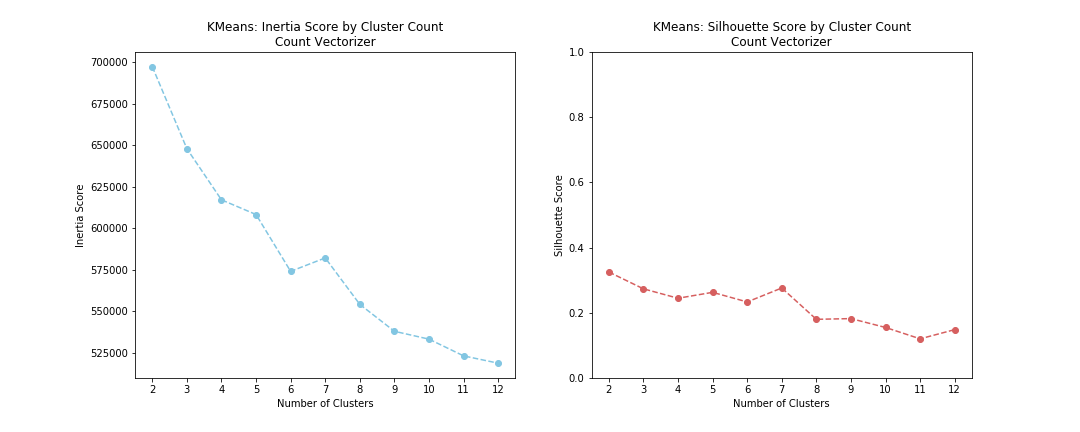

The count vectorizer plots had inertia values that were a factor of over a hundred times higher than all the others, which is why the `y` scale wasn't pegged for them, likely due to the fact those values weren't normalized in any way. It managed the highest overall silhouette scores, though, with the peak value over 0.3 at two clusters.

2) **Hashing Vectorizer with L2 Norm**

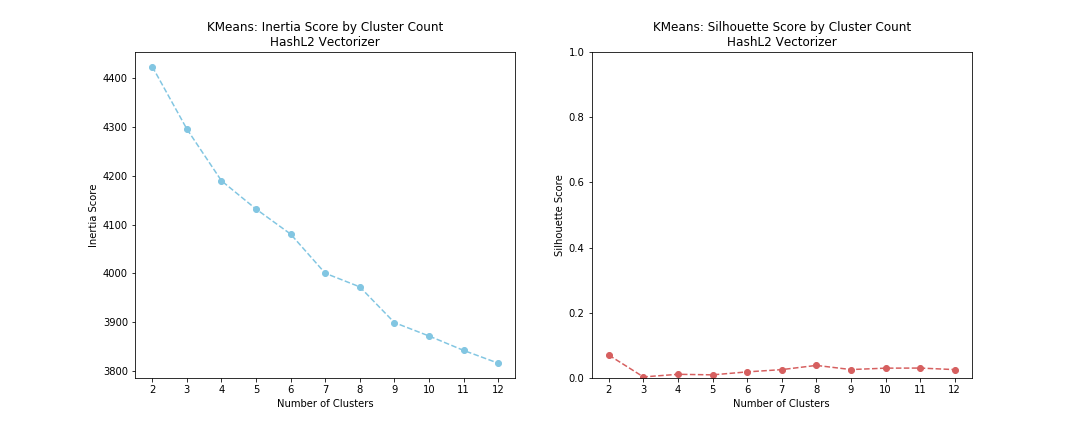

This method had the lowest overall inertia values, but similar silhouette scores as the remaining options.

While the inertia score is the highest for two clusters (as expected), the peak silhouette score favors two clusters. Unfortunately, the silhouette scores are very close to zero, indicating a high degree of overlapping clusters.

3) **Hashing Vectorizer Normalized using TF-IDF**

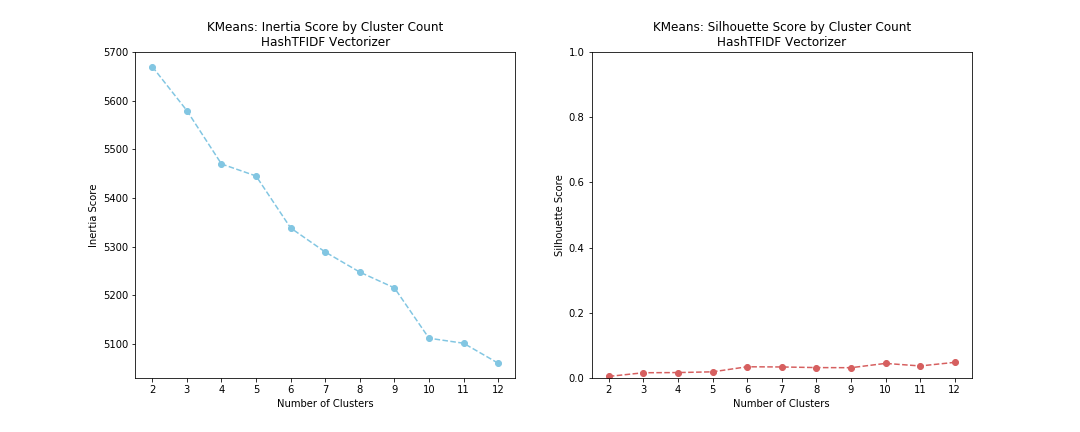

Although a little hard to see given the scale, this analysis shows a story that supports ten clusters. That cluster count has both the near-minimum inertia value as well as the peak silhouette score. However, the overall inertia and silhouette values are worse than the previous analysis using a hashing vectorizer with an L2 norm. The inertia scores are all higher, and the best silhouette score is still below the two-cluster score from that analysis.

4) **TF-IDF Vectorizer**

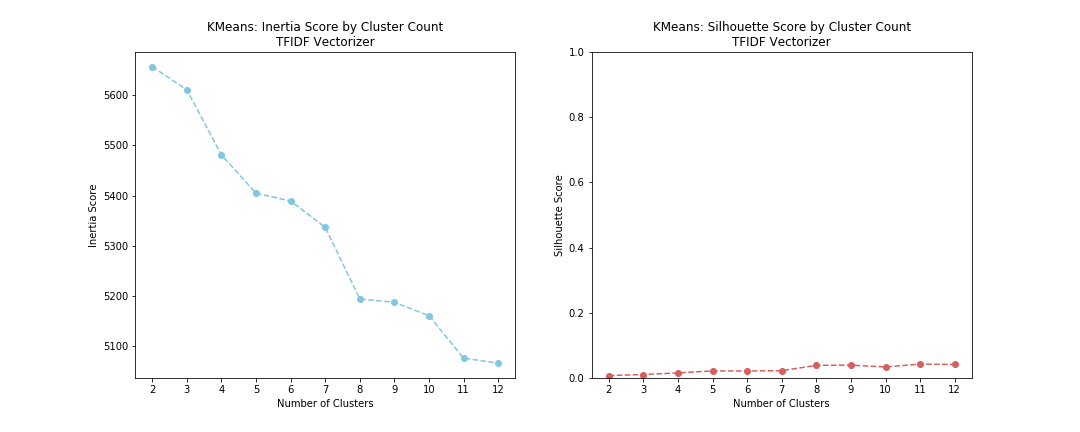

Not surprisingly, this analysis is very similar to the hashing vectorizer with TF-IDF normalization. The overall score values are in line with where they fell out in the other TF-IDF-based analysis. There's no clear optimal number of clusters in these charts, and the silhouette scores seem to continue to climb at the limit of twelve clusters.

In [55]:
# Create KMeans model (count vectorizer, 2 clusters)
X_data = vect_count.fit_transform(X_train['Comment'])
km = KMeans(n_clusters=2,
            max_iter=100,
            n_init=1,
            n_jobs=-1)

km.fit(X_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=1, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [56]:
print('Inertia: {0: ,.0f}'.format(km.inertia_))
print('Silhouette Coefficient: {0:.3f}'.format(
      metrics.silhouette_score(X_data, km.labels_, sample_size=1000)))

Inertia:  697,280
Silhouette Coefficient: 0.307


In [57]:
# Test minibatch
km_mini = MiniBatchKMeans(n_clusters=2,
                          init='k-means++',
                          n_init=1,
                          init_size=1000,
                          batch_size=1000)
km_mini.fit(X_data)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [58]:
print('Inertia: {0: ,.0f}'.format(km_mini.inertia_))
print('Silhouette Coefficient: {0:.3f}'.format(
      metrics.silhouette_score(X_data, km_mini.labels_, sample_size=1000)))

Inertia:  706,999
Silhouette Coefficient: 0.347


In [59]:
# Run minibatch to grab inertias
mini_inertia = []

for k in range(2, 13):
    km_mini_mod = MiniBatchKMeans(n_clusters=k,
                                  init='k-means++',
                                  n_init=1,
                                  init_size=1000,
                                  batch_size=1000)
    km_mini_mod.fit(X_data)
    mini_inertia.append(km_mini_mod.inertia_)

Text(0, 0.5, 'Inertia Score')

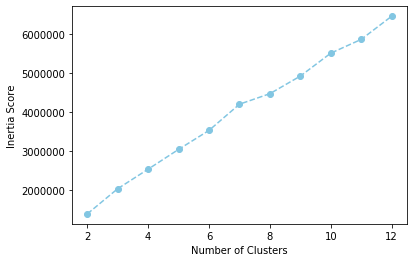

In [60]:
# Plot inertia * number of clusters and look for min
y_s = np.array(mini_inertia) * np.array(list(range(2, 13)))
plt.plot(range(2, 13), y_s, 'o--', c='#82c6e2')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia times Cluster')

### Inspection of Comments in each Cluster

In [131]:
# Print comments from cluster 0
cluster_0 = X_train[km.labels_ == 0]

for idx, row in cluster_0.head(15).iterrows():
    print(row['Comment'])
    print('\n----------\n')

The proposed rule would eliminate entire categories of waterways from the protections afforded by the Clean Water Act, threatening the water you use to drink, grow your food, fish, and recreate. Categories of excluded waterways include: interstate waters, ephemeral streams or other isolated waters, non-adjacent wetlands, ditches, upland waters, and groundwater.The proposed rule disproportionately impacts the western United States by eliminating the Clean Water Acts protections from most waterways and wetlands in New Mexico, Arizona and Nevada.The proposed rule undermines the science supporting an interconnected watershed approach to protect water quality and riparian habitat. More than half of waterways (60 percent) in the United States are ephemeralmeaning water only flows in these creeks or streams for a portion of the yearbut these waterways contribute significant flows and nutrients to our major rivers.In Arizona, New Mexico, Nevada, Utah, Colorado, and California ephemeral streams

In [133]:
# Print comments from cluster 1
cluster_1 = X_train[km.labels_ == 1]

for idx, row in cluster_1.head(20).iterrows():
    print(row['Comment'])
    print('\n----------\n')

S. Waters- I live on the Rappahannock River. I'm concerned this proposed rule would remove protections that impact overall water quality. I rely on this as a source of my drinking water. All this could be harmed by the loss of federal protections. I ask the EPA to keep the Clean Water Act intact.

----------

economy.I am writing in hopes that my words will reach someone who cares about the health of people and life in general. I was shocked to hear the proposal to limit the Clean Water Act. My family & I live on a beautiful lake & regularly fish, swim & kayak in our lake & small streams. Why on earth would people even consider the polluting of our waterways to be acceptable? It just doesnt make any sense. There is obviously money involved. Someone stands to make a profit by allowing this change. This proposal to limit the Clean Water Act must be stopped. We must become better human beings, not worse. We must protect our natural resources if our planet & we are to survive. Regards, Jen

### Dimensionality Reduction with PCA and TSNE to Visualize Clustering Performance

In [138]:
# Reduce dimensions with PCA
pca = PCA(n_components=50)
components = pca.fit_transform(X_data.todense())

print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.27494519 0.06506634 0.04724758 0.02962139 0.02483457 0.01647525
 0.01496704 0.01387719 0.01236948 0.01198932 0.01021018 0.00936799
 0.00815811 0.00765791 0.00731148 0.00713733 0.00660996 0.00639967
 0.00624722 0.00550695 0.00520597 0.00502121 0.00490591 0.00452702
 0.00437648 0.00419566 0.00387697 0.00360942 0.00357453 0.00347452
 0.00337672 0.00327907 0.00319678 0.00318734 0.00304439 0.00296856
 0.00279579 0.00274957 0.00271785 0.00264195 0.00260617 0.00255991
 0.00249542 0.0024418  0.00235215 0.00231499 0.00222145 0.00220632
 0.00217065 0.00214141]


0.6822360991953075

In [139]:
components.shape

(6388, 50)

In [182]:
# Re-create DF with labeled clusters
col_names = ['PCA_{}'.format(i + 1) for i in range(pca.n_components_)]

pca_df = pd.DataFrame(components, columns=col_names, index=X_train.index)
pca_df['Cluster'] = km.labels_

pca_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,...,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,Cluster
5217,-2.851304,-0.100958,-0.156330,-0.509742,-0.051073,-0.574754,0.363693,1.347286,-0.311967,0.070156,-0.958739,-0.292243,-1.123532,1.626756,0.524772,-0.646652,-0.761818,0.451926,-0.726409,0.840924,-0.882668,0.924767,0.002890,0.065961,-0.715864,...,0.950721,-0.909188,-0.238225,-0.104783,-0.109627,-0.041631,0.871261,0.557827,-0.483647,0.107295,0.159418,0.290656,-0.604001,-0.290209,0.342549,0.485914,-0.133705,-0.044080,-0.013461,0.053227,-0.081679,0.058970,-0.207540,-0.029132,1
1866,-3.053875,1.860035,0.637873,0.704148,-0.349024,-0.349207,-0.174443,0.209353,-0.468275,-0.305905,0.358657,-0.712838,0.137255,-0.772468,1.051527,-0.439124,-0.442482,-0.533338,0.368325,-0.261269,0.500978,-1.098540,-0.294599,-0.039892,0.641560,...,0.338152,0.860829,0.621053,-0.619110,-0.038340,-0.239634,-0.038141,-0.461495,-0.179525,-0.174312,-0.042588,-0.708674,0.964818,-0.602019,0.525762,0.174054,-0.213169,-1.398370,0.516378,-1.392401,-0.148313,-0.351363,-0.109253,-0.043963,1
532,-6.309592,-0.063002,0.596040,0.084690,-0.418778,-0.362606,0.022838,0.256570,-0.147422,0.097506,0.163164,-0.142800,-0.049722,-0.274756,0.137288,0.227282,0.253241,0.252392,0.071972,-0.103866,0.081214,-0.021787,0.115796,-0.104904,0.062515,...,0.079307,-0.083981,0.095269,-0.013379,0.103816,-0.016823,-0.127087,-0.005272,0.093808,-0.040398,0.093921,-0.025765,-0.024101,0.080397,-0.091191,0.094051,0.036773,0.043477,0.029254,-0.052620,-0.090347,0.035908,-0.055867,-0.109855,1
5891,-5.607974,-0.261034,1.655045,0.352607,0.605978,-0.591021,1.379258,-0.411086,0.563284,-0.255345,0.869441,0.481140,0.572552,-0.636884,0.253561,0.612392,-0.478429,0.364389,-0.175245,0.154697,-0.532440,-0.318070,-0.353408,-0.457258,0.184464,...,-0.389579,0.623454,0.160597,0.192366,-0.195158,0.333992,0.141092,-0.800360,-0.708106,-0.273366,0.222932,-0.209463,0.317613,0.962481,0.034056,-0.034816,0.156385,0.373971,0.045788,-0.523272,-0.304701,0.186881,-0.113470,0.048361,1
2514,7.733504,-2.180614,1.298220,0.358560,2.779579,-4.011756,5.758036,-5.736720,-4.559243,0.740439,-1.939130,2.419051,-1.268783,-1.756651,-1.068424,0.213479,-0.221810,-0.464007,-0.683465,0.105724,-1.010860,-0.136998,-0.122977,-0.109116,-1.106651,...,0.606476,0.219439,0.507639,-0.691108,0.100729,-0.713009,0.310327,0.172129,0.445468,-0.343358,-0.240906,0.245219,0.609133,0.120846,0.488541,0.451408,-0.125454,0.134944,-0.066992,0.623178,-0.263182,0.174723,0.281135,0.269263,0


In [155]:
# Take sample of 100 supportive, 100 opposing comment labels
samp_0 = y_labeled_train[y_labeled_train == 0].sample(n=100,
                                                      replace=False,
                                                      random_state=42)

samp_1 = y_labeled_train[y_labeled_train == 1].sample(n=100,
                                                      replace=False,
                                                      random_state=42)
labels = pd.concat([samp_0, samp_1])

In [183]:
samples = pd.merge(labels, pca_df[['PCA_1', 'PCA_2']],
                   left_index=True,
                   right_index=True)

samples.tail(10)

,Support_Rule_Change,PCA_1,PCA_2
1166,1.0,-6.557238,-0.268888
8092,1.0,-5.703307,-0.470974
8160,1.0,5.981614,-1.397168
1099,1.0,-5.354106,-0.880294
2272,1.0,-0.629963,-1.698297
165,1.0,-6.459470,-0.376776
488,1.0,-1.318938,-0.718969
405,1.0,9.958388,-7.548046
22,1.0,-4.713397,0.096875
8133,1.0,3.790524,-2.399628


In [157]:
samples.shape

(200, 3)

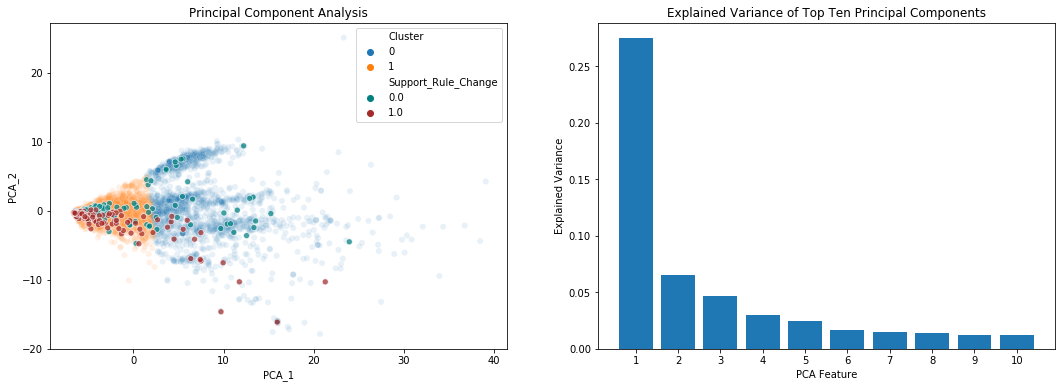

In [188]:
# Plot first two principal components and explained variance
plt.subplots(1, 2, figsize=(18, 6));
plt.subplot(1, 2, 1);
sns.scatterplot(x='PCA_1', y='PCA_2',
                data=pca_df,
                hue='Cluster',
                alpha=0.1);

sns.scatterplot(x='PCA_1', y='PCA_2',
                data=samples,
                hue='Support_Rule_Change',
                alpha=0.7,
                palette=['teal', 'brown']);

plt.title('Principal Component Analysis');

feats = range(1, 11)
plt.subplot(1, 2, 2);
plt.bar(feats, pca.explained_variance_ratio_[:10]);
plt.xticks(feats);
plt.xlabel('PCA Feature');
plt.ylabel('Explained Variance');
plt.title('Explained Variance of Top Ten Principal Components');

# plt.savefig('./Figures/PCA.png');

**Key Takeaways**

The crisp boundary line evident between clusters in the PCA chart (the blue and orange-colored blobs) indicates that the clustering algorithm reduced the problem in a similar manner. (The principal components were not used as features to train the KMeans algorithm). However, where the clustering splits the mass into left and right groups in the visualization, the labels are oriented in top and bottom 'stripes' (with plenty of overlap in the far-left wedge). Other than pockets of same-labeled groups, this analysis doesn't show two clear clusters based on comment sentiment.

In [173]:
# TSNE cluster visualization
tsne = TSNE(n_components=2, perplexity=30)
tsne_res = tsne.fit_transform(X_data)

In [181]:
tsne_res.shape

(6388, 2)

In [186]:
# Re-create DF with TSNE results
tsne_df = pd.DataFrame(tsne_res, columns=['TSNE_1', 'TSNE_2'], index=X_train.index)
tsne_df['Cluster'] = km.labels_

tsne_df.head()

,TSNE_1,TSNE_2,Cluster
5217,-0.221399,31.151783,1
1866,-4.303477,-2.552237,1
532,-36.174049,-3.486159,1
5891,-32.151222,3.700987,1
2514,3.707009,48.464596,0


In [187]:
# Create TSNE sample DF
tsne_samples = pd.merge(labels, tsne_df[['TSNE_1', 'TSNE_2']],
                        left_index=True,
                        right_index=True)

tsne_samples.tail(10)

,Support_Rule_Change,TSNE_1,TSNE_2
1166,1.0,-35.310616,-6.241392
8092,1.0,-44.122993,6.502597
8160,1.0,2.293077,-37.594307
1099,1.0,-24.377684,2.111658
2272,1.0,-0.373486,-32.693157
165,1.0,-35.071865,-5.813413
488,1.0,8.088800,-18.132029
405,1.0,17.838987,-48.214706
22,1.0,-47.749512,0.488553
8133,1.0,1.698636,-37.461685


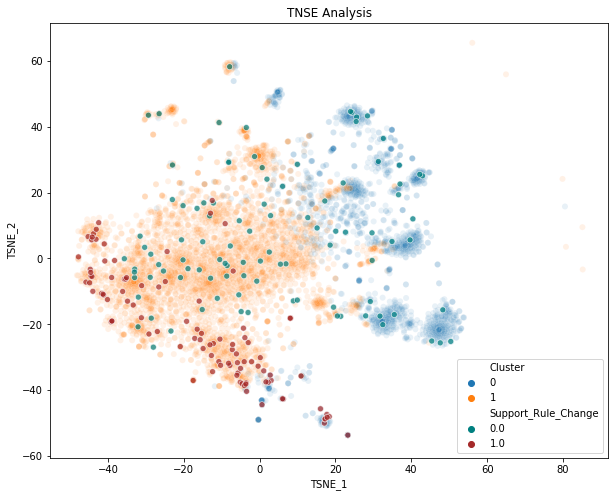

In [191]:
# Plot the TSNE results
plt.figure(figsize=(10, 8));
sns.scatterplot(x='TSNE_1', y='TSNE_2',
                data=tsne_df,
                hue='Cluster',
                alpha=0.1);

sns.scatterplot(x='TSNE_1', y='TSNE_2',
                data=tsne_samples,
                hue='Support_Rule_Change',
                alpha=0.7,
                palette=['teal', 'brown']);

plt.title('TNSE Analysis');
plt.savefig('./Figures/TSNE.png')

## <a name="sentiment-analysis"></a>Sentiment Analysis

This section will only use the labeled training and test sets, created above in `X_labeled_train`, `X_labeled_test`, `y_labeled_train`, and `y_labeled_test`. The imbalance between the classes in the dataset (~80% opposing comments vs. ~20% supportive) may cause issues. To address this, datasets using up- and down-sampling techniques to balance the classes were created, and models trained with each were compared for performance impacts. A simple Multinomial Naive Bayes classifier was selected to be the baseline model.

The small size of the dataset (even after up-sampling) lended itself better to simpler algorithms.

In [194]:
# Calculate percentage of supporting vs. opposing comments
perc_sup = y_labeled_train.mean()*100

print('Supportive comments: {0:.1f}%'.format(perc_sup))
print('Opposing comments: {0:.1f}%'.format(100-perc_sup))

Supportive comments: 20.3%
Opposing comments: 79.7%



TODO:
- establish baseline model
- compare performance of models using upsampled and downsampled datasets to baseline model
- create set of classifiers, run different vectorizers, use bigrams, compare performance

### Create a Baseline Model

In [206]:
# Vectorize labeled training data
X_lab_data = vect_count.fit_transform(X_labeled_train['Comment'])

In [207]:
# Create simple baseline model
nb = MultinomialNB()

nb.fit(X_lab_data, y_labeled_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [330]:
nb_preds = nb.predict(X_lab_data)

In [331]:
# Review confusion matrix and classification report
print(metrics.confusion_matrix(y_labeled_train, nb_preds))
print(metrics.classification_report(y_labeled_train, nb_preds))

[[753  12]
 [  6 189]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       765
         1.0       0.94      0.97      0.95       195

    accuracy                           0.98       960
   macro avg       0.97      0.98      0.97       960
weighted avg       0.98      0.98      0.98       960



In [332]:
# Cross-validated accuracy scores
print('Training accuracy score: {0:.3f}%'.format(nb.score(X_lab_data, y_labeled_train)*100))
print('5-Fold cross-validated accuracy scores')
cv_acc = cross_val_score(nb, X_lab_data, y_labeled_train, scoring='accuracy', cv=5, n_jobs=-1)
print(cv_acc)
print('Average CV score: {0:.4f}%'.format(np.mean(cv_acc)*100))

Training accuracy score: 98.125%
5-Fold cross-validated accuracy scores
[0.96354167 0.97395833 0.94270833 0.96875    0.97395833]
Average CV score: 96.4583%


In [333]:
# Cross-validated f1 scores
print('Training f1 score: {0:.3f}%'.format(metrics.f1_score(y_labeled_train, nb_preds)*100))
print('5-Fold cross-validated f1 scores')
cv_f1 = cross_val_score(nb, X_lab_data, y_labeled_train, scoring='f1', cv=5, n_jobs=-1)
print(cv_f1)
print('Average CV score: {0:.4f}%'.format(np.mean(cv_f1)*100))

Training f1 score: 95.455%
5-Fold cross-validated f1 scores
[0.91566265 0.93670886 0.86419753 0.925      0.93506494]
Average CV score: 91.5327%


The `f1` scores are coming out in the low-90%'s for the baseline MultiNomial Naive Bayes classifier, using a simple count vectorizer on the full, un-resampled dataset.

The next step is to test whether up/down sampling the dataset improves model performance by comparing the results against this baseline model's `f1` score.

### Compare Baseline Model Performance to Models Using Resampled Datasets

In [219]:
# Test if up/down sampling improves performance
df_sup = support_train.copy()
df_sup['Support_Rule_Change'] = y_train[y_train == 1]
# df_sup.head()  # len: 765

df_opp = oppose_train.copy()
df_opp['Support_Rule_Change'] = y_train[y_train == 0]
df_opp.head()  # len: 195

,Comment,Support_Rule_Change
1104,Please do not support the rollback of the clea...,0.0
65,"We need to be doing more, not less, to protect...",0.0
1074,Please keep the 2015 WOTUS legislation. PLEAS...,0.0
8018,"We need to be doing more, not less, to PROTECT...",0.0
1107,"As stated, the overall objective of the CWA to...",0.0


In [225]:
# Uses support_train and oppose_train created for the word clouds
# Upsample supporting comments
sup_upsamp = resample(df_sup,
                      replace=True,
                      n_samples=len(df_opp),
                      random_state=42)

upsampled = pd.concat([sup_upsamp, df_opp])
print(upsampled.shape)

X_up_train = upsampled.drop('Support_Rule_Change', axis=1)
y_up_train = upsampled['Support_Rule_Change']
print(X_up_train.shape, y_up_train.shape)

(1530, 2)
(1530, 1) (1530,)


In [227]:
# Refit model with upsampled data to compare to baseline
X_up_data = vect_count.fit_transform(X_up_train['Comment'])

nb_upsamp = MultinomialNB()
nb_upsamp.fit(X_up_data, y_up_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [233]:
preds_up = nb_upsamp.predict(X_up_data)

print('Accuracy score: {0:.3f}%'.format(nb_upsamp.score(X_up_data, y_up_train)*100))

Accuracy score: 98.562%


In [234]:
print(metrics.confusion_matrix(y_up_train, preds_up))
print(metrics.classification_report(y_up_train, preds_up))

[[754  11]
 [ 11 754]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       765
         1.0       0.99      0.99      0.99       765

    accuracy                           0.99      1530
   macro avg       0.99      0.99      0.99      1530
weighted avg       0.99      0.99      0.99      1530



In [235]:
# Uses support_train and oppose_train created for the word clouds
# Down-sample opposing comments
opp_downsamp = resample(df_opp,
                        replace=True,
                        n_samples=len(df_sup),
                        random_state=42)

downsampled = pd.concat([opp_downsamp, df_sup])
print(downsampled.shape)

X_down_train = downsampled.drop('Support_Rule_Change', axis=1)
y_down_train = downsampled['Support_Rule_Change']
print(X_down_train.shape, y_down_train.shape)

(390, 2)
(390, 1) (390,)


In [237]:
# Refit model with downsampled data to compare to baseline
X_down_data = vect_count.fit_transform(X_down_train['Comment'])

nb_downsamp = MultinomialNB()
nb_downsamp.fit(X_down_data, y_down_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [238]:
preds_down = nb_downsamp.predict(X_down_data)

print('Accuracy score: {0:.3f}%'.format(nb_downsamp.score(X_down_data, y_down_train)*100))

Accuracy score: 97.949%


In [239]:
print(metrics.confusion_matrix(y_down_train, preds_down))
print(metrics.classification_report(y_down_train, preds_down))

[[190   5]
 [  3 192]]
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       195
         1.0       0.97      0.98      0.98       195

    accuracy                           0.98       390
   macro avg       0.98      0.98      0.98       390
weighted avg       0.98      0.98      0.98       390



In [329]:
# Cross-validated scores for baseline, upsampled, and downsampled models
scoring = 'f1'
print('5-Fold cross-validated {} scores'.format(scoring))

for mod_name, mod, data, y_vals in zip(['Baseline', 'Upsampled', 'Downsampled'],
                                       [nb, nb_upsamp, nb_downsamp],
                                       [X_lab_data, X_up_data, X_down_data],
                                       [y_labeled_train, y_up_train, y_down_train]):
    print(mod_name.upper())
    perf = cross_val_score(mod, data, y_vals, scoring=scoring, cv=5, n_jobs=-1)
    print(perf)
    print('Mean CV Score: {0:.4f}'.format(np.mean(perf)))
    print('-'*30)

5-Fold cross-validated f1 scores
BASELINE
[0.91566265 0.93670886 0.86419753 0.925      0.93506494]
Mean CV Score: 0.9153
------------------------------
UPSAMPLED
[0.97385621 0.9869281  0.98051948 0.95709571 0.99346405]
Mean CV Score: 0.9784
------------------------------
DOWNSAMPLED
[0.975      0.97435897 0.93150685 0.94871795 0.94871795]
Mean CV Score: 0.9557
------------------------------


**Sampling Takeaways**

Both upsampling and downsampling techniques improved the 5-fold cross-validated `f1` scores over the baseline model, with a slight advantage going to the upsampled model.

The `accuracy` scores were much closer, with the upsampled model out-performing the baseline by a little over a percent (average across the 5-fold CV scores), but the downsampled model lagged the baseline performance by around 2%.

`precision` scores followed the `f1` score trends, with the upsampled model in the lead, followed by the downsampled one, with both 6-8% higher scores over the average CV scores for the baseline model.

Finally, `recall` followed the same patterns as `f1` and `precision` (the upsampled model in the lead, the downsampled one next, with the baseline model last), but with average scores a few percentage points apart.

Given the consistency in the scoring trends, the upsampled dataset will be used going forward to compare different classifiers.

### Compare Performance of Various Classification Models

In [334]:
X_up_tf = vect_tfidf.fit_transform(X_up_train['Comment'])

In [335]:
tf_nb = MultinomialNB()

tf_nb.fit(X_up_tf, y_up_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [336]:
cross_val_score(tf_nb, X_up_tf, y_up_train, scoring='accuracy', cv=5, n_jobs=-1)

array([0.98039216, 0.99346405, 0.98039216, 0.9869281 , 0.99346405])

In [337]:
cross_val_score(tf_nb, X_up_tf, y_up_train, scoring='f1', cv=5, n_jobs=-1)

array([0.98039216, 0.99350649, 0.98051948, 0.98709677, 0.99346405])

In [ ]:
# Quickly compare several baseline models
mod_dict = {
    'MultiNB': MultinomialNB(),
    'ComplementNB': ComplementNB()
}

In [328]:
titles

['Count', 'HashL2', 'HashTFIDF', 'TFIDF']

## <a name="conclusions"></a>Conclusions

A write-up of the project's conclusions has been moved to the [repository website](https://data-science-for-conservation.github.io/WOTUS_Revision/#conclusions).